In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib as mpl
import h5py
import numpy as np
from Allineamento import *

In [2]:
def projectDistZ(x1,x2,y1,y2,d12,z):
    mx = (x2-x1)/d12
    xProj = x1 + mx * z
    
    my = (y2-y1)/d12
    yProj = y1 + my * z
    
    return (xProj, yProj)

def get_theta_angles(x1, y1, x2, y2, d):
    import numpy as np
    thetaX = np.arctan((x2-x1)/d) #rad
    thetaY = np.arctan((y2-y1)/d) #rad
    return (thetaX, thetaY)


def file_loader(run_number):
    """
    Load the data file for a given run number.
    """
    data_path =f'data/TB_T9_2025/run{run_number}.h5'
    # print('opening ', data_path) 
    pos = []
    phs = []
    tmis =[]
    qtots =[]
    nclus = []
    info_pluss =[]
    xinfos =[]
    with h5py.File(data_path, 'r', libver='latest', swmr=True) as hf:
        print(hf.keys())
        hf["xpos"].shape
        keys = list(hf.keys())
        pos.append(np.array(hf['xpos']))
        phs.append(np.array(hf['digiPH'])) # from 24
        tmis.append(np.array(hf['digiTime'])) # from 24
        qtots.append(np.array(hf['qtot'])) # from 24
        nclus.append(np.array(hf['nclu'])) # from 24
        info_pluss.append(np.array(hf['info_plus']))
        xinfos.append(np.array(hf['xinfo']))
        #for k in hf.keys():
        #    comand = f'{k} = np.array(hf["{k}"])'
            # print(comand)
        #  exec(comand)
    xpos = np.concatenate(pos,axis=0)
    ph = np.concatenate(phs,axis=0)
    tm = np.concatenate(tmis,axis=0)
    qtot = np.concatenate(qtots,axis=0)
    nclu = np.concatenate(nclus,axis=0)
    info_plus = np.concatenate(info_pluss,axis=0)
    xinfo = np.concatenate(xinfos,axis=0)
    print('xpos shape', xpos.shape)
    print('N spill: ', info_plus[:,0][-1])
    print(np.unique(xinfo[:,1]))
        # print('xpos shape', xpos.shape)

    x1 = xpos[:,1]
    y1 = xpos[:,0]
    x2 = xpos[:,2] - offset_x2
    y2 = xpos[:,3] - offset_y2
    x3 = xpos[:,4]
    y3 = xpos[:,5]

    Calibration = False
    if Calibration:
        q = -25.84
        m = 323.4
        ph[:,2]=  (ph[:,2] - q)/m

    xcry, ycry = projectDistZ(x1,x2,y1,y2,d12,d1c)
    theta_x_in, theta_y_in = get_theta_angles(x1, y1, x2, y2, d12)
    theta_x_out, theta_y_out = get_theta_angles(xcry, ycry, x3, y3, dc3)


    ph_calo_photon = ph[:,2]
    ph_cherry1 = ph[:,0]

    return x1, y1, x2, y2, x3, y3, xcry, ycry, ph_calo_photon, ph_cherry1, \
    theta_x_in, theta_y_in, theta_x_out, theta_y_out, tm, qtot, nclu, info_plus,xinfo


In [3]:
run_number = 730156

d12 = 330 ## cm
d23 = 66.8
d1c = 330 + 53.2 #cm
dc3 = 10.7 
d1calo = d1c + 779.2 

offset_x2 =   -0.19494474108211143
offset_y2 =   2.276578722633391 

range_chamber = ((0,10),(0,10))
bins2d = (100,100)
mycmap = 'jet'

opt_hist = {'histtype': 'step', 'lw': 1.5, 'alpha': 0.8}
opts_2d = { "cmap" : mycmap, "bins" : bins2d} # "norm" : mpl.colors.LogNorm()}

th_cherry1 = 20
th_cherry2 = 20


<KeysViewHDF5 ['digiBase', 'digiPH', 'digiTime', 'info_plus', 'nclu', 'qtot', 'xinfo', 'xpos']>
xpos shape (27369, 6)
N spill:  83
[0.]
730147 -- N spill: 83 -- events: 27369 -- evs/spill: 330
<KeysViewHDF5 ['digiBase', 'digiPH', 'digiTime', 'info_plus', 'nclu', 'qtot', 'xinfo', 'xpos']>
xpos shape (18509, 6)
N spill:  68
[-2120.575]
730157 -- N spill: 68 -- events: 18509 -- evs/spill: 272
<KeysViewHDF5 ['digiBase', 'digiPH', 'digiTime', 'info_plus', 'nclu', 'qtot', 'xinfo', 'xpos']>
xpos shape (34399, 6)
N spill:  88
[54999.688]
730159 -- N spill: 88 -- events: 34399 -- evs/spill: 391


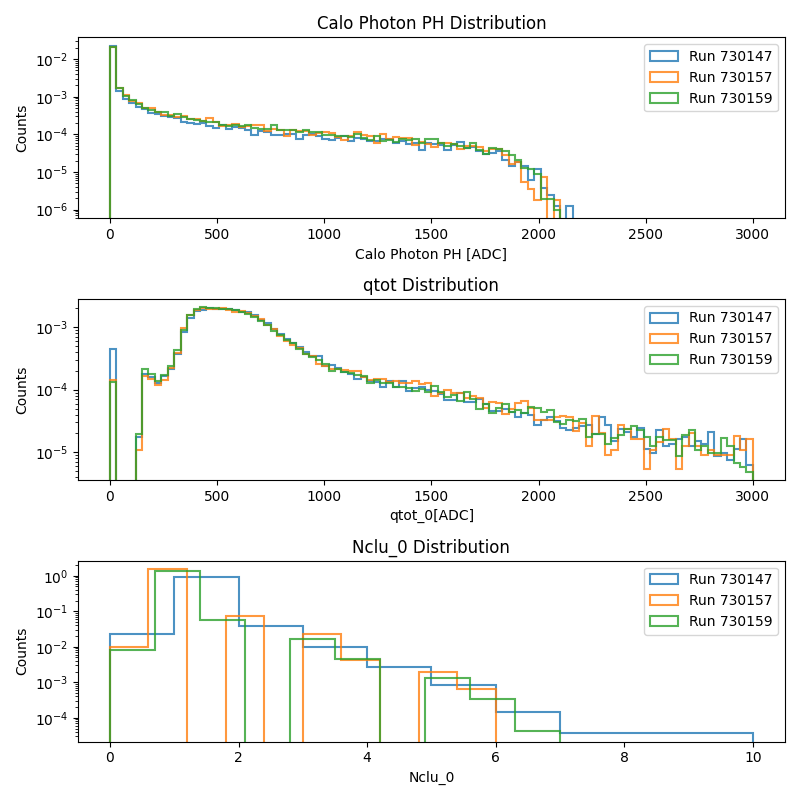

In [4]:
run_list = [730147,730157,730159]

x_cry_cut = [4.28, 4.67]
y_cry_cut = [7.40, 7.8]


fig,ax = plt.subplots(3,figsize=(8, 8)) 
for run_number in run_list:
    x1, y1, x2, y2, x3, y3, xcry, ycry, ph_calo_photon, ph_cherry1, \
    theta_x_in, theta_y_in, theta_x_out, theta_y_out, tm, qtot, nclu, info_plus,xinfo = file_loader(run_number)

    logi = ph_cherry1>th_cherry1 & (xcry>x_cry_cut[0]) & (xcry<x_cry_cut[1]) & (ycry>y_cry_cut[0]) & (ycry<y_cry_cut[1])

    ax[0].hist(ph_calo_photon[logi],bins =100 ,range = (0,3000), label =f'Run {run_number}',density= True, **opt_hist)

    ax[1].hist(qtot[:,0][logi],bins =100 ,range = (0,3000), label =f'Run {run_number}',density= True, **opt_hist)
    
    ax[2].hist(nclu[:,0][logi], label =f'Run {run_number}',density= True, **opt_hist)
    print(f'{run_number} -- N spill: {info_plus[:,0][-1]} -- events: {len(ph_calo_photon)} -- evs/spill: {len(ph_calo_photon)/info_plus[:,0][-1]:.0f}')
ax[0].set_xlabel('Calo Photon PH [ADC]')
ax[0].set_ylabel('Counts')
ax[0].set_title('Calo Photon PH Distribution')
ax[0].legend()
ax[0].set_yscale('log')
ax[1].set_xlabel('qtot_0[ADC]')
ax[1].set_ylabel('Counts')
ax[1].set_title('qtot Distribution')
ax[1].legend()
ax[1].set_yscale('log')
ax[2].set_xlabel('Nclu_0')
ax[2].set_ylabel('Counts')
ax[2].set_title('Nclu_0 Distribution')
ax[2].legend()
ax[2].set_yscale('log')
plt.tight_layout()
plt.show()

## code for a scan (to be tested )

<KeysViewHDF5 ['digiBase', 'digiPH', 'digiTime', 'info_plus', 'nclu', 'qtot', 'xinfo', 'xpos']>
xpos shape (310854, 6)
N spill:  806
[-23119.678   -20619.143   -18120.533   -15620.523   -13119.814
 -10619.106    -8118.1362   -5620.4844   -3117.1577    -619.06836
   1881.3604    4379.5557    6880.2632    9380.7939   11881.503
  14379.59     16880.129    19380.836    21881.545  ]


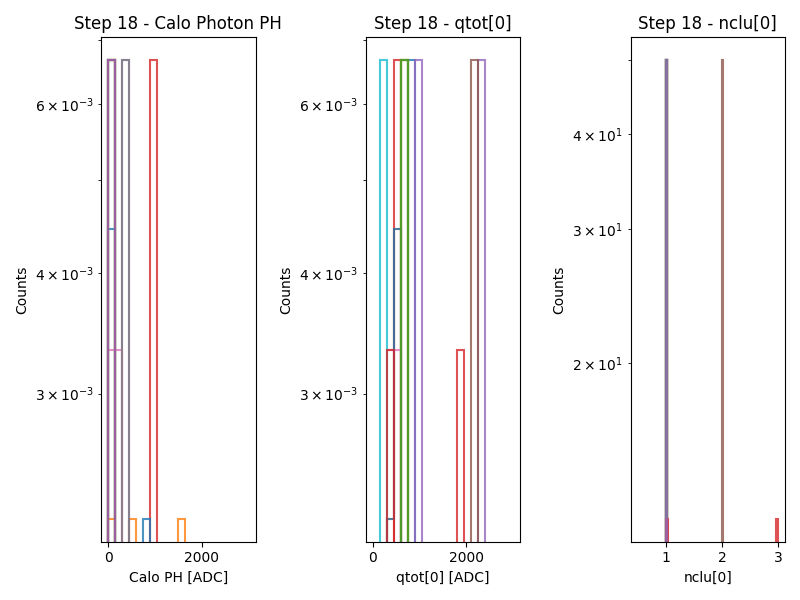

In [10]:
scan_number = 730158

# Caricamento dei dati (assumendo 1 solo run)
x1, y1, x2, y2, x3, y3, xcry, ycry, ph_calo_photon, ph_cherry1, \
theta_x_in, theta_y_in, theta_x_out, theta_y_out, tm, qtot, nclu, info_plus,xinfo = file_loader(scan_number)

unique_steps = np.unique(info_plus[:, 1])
n_steps = len(unique_steps)

fig, axs = plt.subplots(1, 3, figsize=(8,6))

for i, step in enumerate(unique_steps):
    logi = (ph_cherry1 > th_cherry1) & (info_plus[:, 1] == step) & (xcry>x_cry_cut[0]) & (xcry<x_cry_cut[1]) & (ycry>y_cry_cut[0]) & (ycry<y_cry_cut[1])
        

    if np.sum(logi) == 0:
        continue

    axs[0].hist(ph_calo_photon[logi], bins=20, range=(0, 3000), label=f'Step {step}', density=True, **opt_hist)
    axs[1].hist(qtot[:, 0][logi], bins=20, range=(0, 3000), label=f'Step {step}', density=True, **opt_hist)
    axs[2].hist(nclu[:, 0][logi], bins=50, label=f'Step {step}', density=True, **opt_hist)

    axs[0].set_title(f'Step {step} - Calo Photon PH')
    axs[1].set_title(f'Step {step} - qtot[0]')
    axs[2].set_title(f'Step {step} - nclu[0]')

    for j in range(3):
        axs[j].set_yscale('log')
        # axs[j].legend()
        axs[j].set_xlabel(['Calo PH [ADC]', 'qtot[0] [ADC]', 'nclu[0]'][j])
        axs[j].set_ylabel('Counts')

plt.tight_layout()
plt.show()


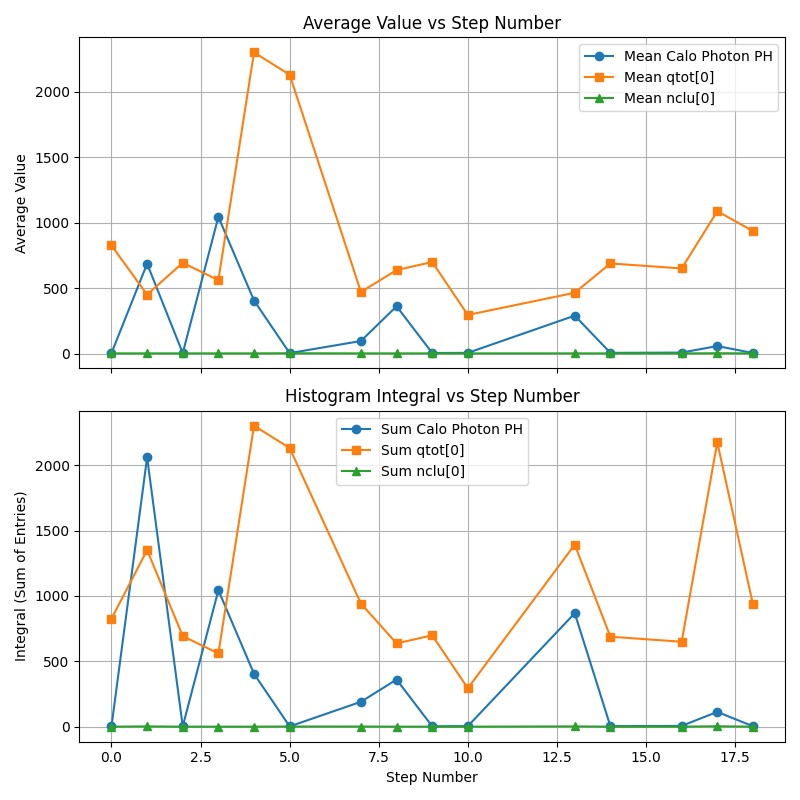

In [6]:
# Storage for plotting
steps = []
mean_ph_calo = []
mean_qtot0 = []
mean_nclu0 = []

sum_ph_calo = []
sum_qtot0 = []
sum_nclu0 = []

for step in unique_steps:
    logi = (ph_cherry1 > th_cherry1) & (info_plus[:, 1] == step) & (xcry>x_cry_cut[0]) & (xcry<x_cry_cut[1]) & (ycry>y_cry_cut[0]) & (ycry<y_cry_cut[1])

    if np.sum(logi) == 0:
        continue

    steps.append(step)

    ph = ph_calo_photon[logi]
    qt = qtot[:, 0][logi]
    nc = nclu[:, 0][logi]

    mean_ph_calo.append(np.mean(ph))
    mean_qtot0.append(np.mean(qt))
    mean_nclu0.append(np.mean(nc))

    sum_ph_calo.append(np.sum(ph))
    sum_qtot0.append(np.sum(qt))
    sum_nclu0.append(np.sum(nc))

# Convert to numpy arrays
steps = np.array(steps)

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

# Average value plot
axs[0].plot(steps, mean_ph_calo, 'o-', label='Mean Calo Photon PH')
axs[0].plot(steps, mean_qtot0, 's-', label='Mean qtot[0]')
axs[0].plot(steps, mean_nclu0, '^-', label='Mean nclu[0]')
axs[0].set_ylabel('Average Value')
axs[0].set_title('Average Value vs Step Number')
axs[0].legend()
axs[0].grid(True)

# Integral (sum) plot
axs[1].plot(steps, sum_ph_calo, 'o-', label='Sum Calo Photon PH')
axs[1].plot(steps, sum_qtot0, 's-', label='Sum qtot[0]')
axs[1].plot(steps, sum_nclu0, '^-', label='Sum nclu[0]')
axs[1].set_xlabel('Step Number')
axs[1].set_ylabel('Integral (Sum of Entries)')
axs[1].set_title('Histogram Integral vs Step Number')
axs[1].legend()
axs[1].grid(True)

fig.savefig(f'plots/{scan_number}_step_scan.png', dpi=300)
plt.tight_layout()
plt.show()


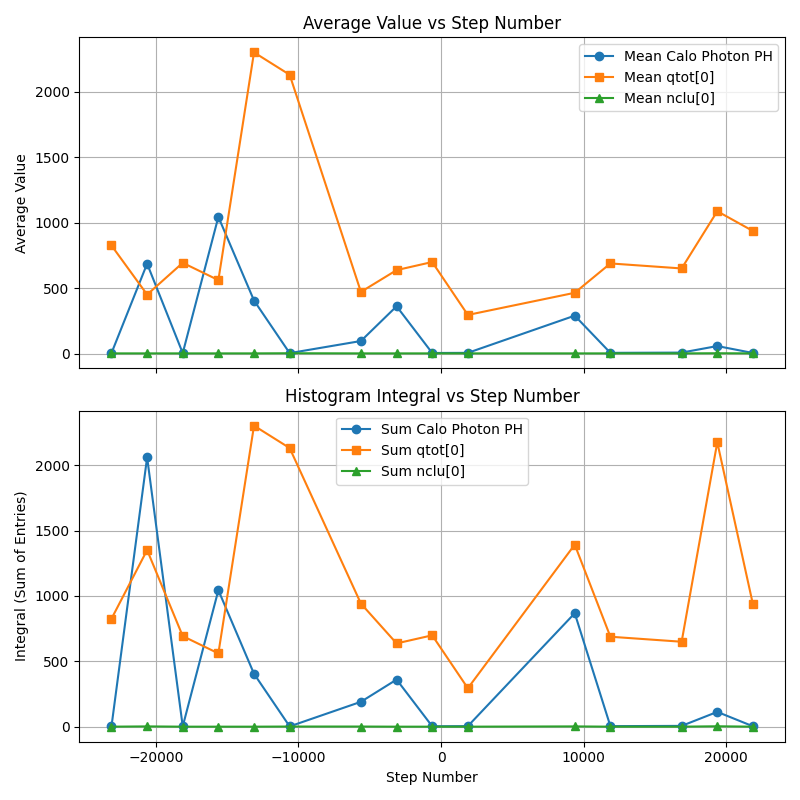

In [7]:

steps = []
mean_ph_calo = []
mean_qtot0 = []
mean_nclu0 = []

sum_ph_calo = []
sum_qtot0 = []
sum_nclu0 = []
unique_steps = np.unique(xinfo[:, 1])
n_steps = len(unique_steps)
for step in unique_steps:
    logi = (ph_cherry1 > th_cherry1) & (xinfo[:, 1] == step) & (xcry>x_cry_cut[0]) & (xcry<x_cry_cut[1]) & (ycry>y_cry_cut[0]) & (ycry<y_cry_cut[1])

    if np.sum(logi) == 0:
        continue

    # steps.append(step+theta_y_in)
    steps.append(step)

    ph = ph_calo_photon[logi]
    qt = qtot[:, 0][logi]
    nc = nclu[:, 0][logi]

    mean_ph_calo.append(np.mean(ph))
    mean_qtot0.append(np.mean(qt))
    mean_nclu0.append(np.mean(nc))

    sum_ph_calo.append(np.sum(ph))
    sum_qtot0.append(np.sum(qt))
    sum_nclu0.append(np.sum(nc))

# Convert to numpy arrays
steps = np.array(steps)

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

# Average value plot
axs[0].plot(steps, mean_ph_calo, 'o-', label='Mean Calo Photon PH')
axs[0].plot(steps, mean_qtot0, 's-', label='Mean qtot[0]')
axs[0].plot(steps, mean_nclu0, '^-', label='Mean nclu[0]')
axs[0].set_ylabel('Average Value')
axs[0].set_title('Average Value vs Step Number')
axs[0].legend()
axs[0].grid(True)

# Integral (sum) plot
axs[1].plot(steps, sum_ph_calo, 'o-', label='Sum Calo Photon PH')
axs[1].plot(steps, sum_qtot0, 's-', label='Sum qtot[0]')
axs[1].plot(steps, sum_nclu0, '^-', label='Sum nclu[0]')
axs[1].set_xlabel('Step Number')
axs[1].set_ylabel('Integral (Sum of Entries)')
axs[1].set_title('Histogram Integral vs Step Number')
axs[1].legend()
axs[1].grid(True)

fig.savefig(f'plots/{scan_number}_step_scan.png', dpi=300)
plt.tight_layout()
plt.show()
